
# Winter school - IMB

## scRNA-seq


In this tutorial, we will get familiar with single cell sequencing (scRNA-seq) gene expression data. We will go through several main analysis types, including preprocessing, clustering, and differential gene expression.



### Resources

Often, there is a need to have a common analysis framework that allows the broad research community to use as a starting point for the analysis to establish baseline results that can be comparable across research groups, projects and technologies. Scanpy (Python) and Seurat (R) are such frameworks for single cell analysis. Imporantly, it is necessary to understand the background theory and the low-level codes behind convenient wrapper functions. For this tutorial, a reference list for Seurat functions can be found here: https://satijalab.org/seurat/reference/ 

For scRNA-seq data, over 30 analysis types and more than 1500 software programs are available. These programs are written in different languages, most commonly in R and Python. For updated information about the scRNA-seq analysis software collection, refer to scRNAtool website, https://www.scrna-tools.org/. 

## 1. Setting up 
### 1.1 Seurat data object 


Single cell data has multiple layers of information, not just the large gene expression matrix. Often, the expression matrix is ~1000 times larger than a traditional RNA-seq dataset. Additional layers, for example, include information about the cell type of each cell, the sequencing experiment condition (batch), genes and gene groups, and various dimensionality reduction matrices, or even images of the tissues where the single cells were extracted. To handle all information in one R object, we use Seurat object structure, with the aim to provide a common framework for various R-based software to work with single cell data.

<p align="center">
<img src="https://slidetodoc.com/presentation_image_h/eee337103f9e402fba4c058500c42101/image-8.jpg" alt="" width="800"/>
</p>

The diagram above describes the structure of an SeuratObject. SeuratObject stores four main slots (layers): 1) Asssay, 2) Metadata, 3) Embedding,  and 4) Variable Features. Each component has one or several datatypes


## 2. The PBMC dataset 

To get a good feel of scRNAseq data and key analysis types, we will use a 'small' dataset with 2,700 Peripheral Blood Mononuclear Cells (PBMC). The PBMC dataset has well-characterised immune cell types. This dataset has been used by researchers around the world as one of the gold-standard dataset for the development and comparison of new analysis methods. 

We have provided this data already. If you are interested in exploring a similar, but larger dataset, you can try downloading the PBMC 68,000 cells at https://cf.10xgenomics.com/samples/cell-exp/1.1.0/fresh_68k_pbmc_donor_a/fresh_68k_pbmc_donor_a_filtered_gene_bc_matrices.tar.gz. With this larger dataset, you will need a large RAM and some steps (e.g. PCA) will take longer to run. 

In [1]:
library(Seurat)
library(tidyverse)
library(stringr)
library(stats)
options(warn=-1)

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.3.2 but the current version is
4.3.3; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-li

### 2.1 Load the data 
- There are multiple ways to load single cell data. Typically, a single cell dataset after mapping reads to the genome will contain three main components:  barcodes.tsv (cell IDs), genes.tsv, matrix.mtx (expression matrix).

- We will load the data in the typical way for scRNA-seq data from the 10X platform, as is usually outputted by the 'CellRanger' software. 

In [111]:
#############################
#   Loading the Data   # 
#############################

expression_matrix = Read10X('/data/module2/data/prac1_singlecell/filtered_gene_bc_matrices/hg19',  # the directory with the `.mtx` file  
    )
pbmc <- CreateSeuratObject(counts = expression_matrix)

In [3]:
pbmc

An object of class Seurat 
32738 features across 2700 samples within 1 assay 
Active assay: RNA (32738 features, 0 variable features)
 1 layer present: counts

#### The Nature of the Data

- Single cell RNA-seq is plagued with a large source of technical variation - an extremely low sampling of the total number of mRNAs captured by the cell. The result of this is that there are few genes captured per cell; and typically few reads per gene. This results in what is referred to as a 'sparse matrix'; whereby the majority of values within the matrix are '0'. 

- Below, we illustrate this by visualising this matrix; rows are genes, columns are cells.

<font color='red'> **Question**: plot a graph to visualise the sparsity of the pbmc single cell gene expression matrix <font> 

In [4]:
subsample <- as.matrix(pbmc@assays$RNA@layers$counts[1:100,1:100] >0.5)

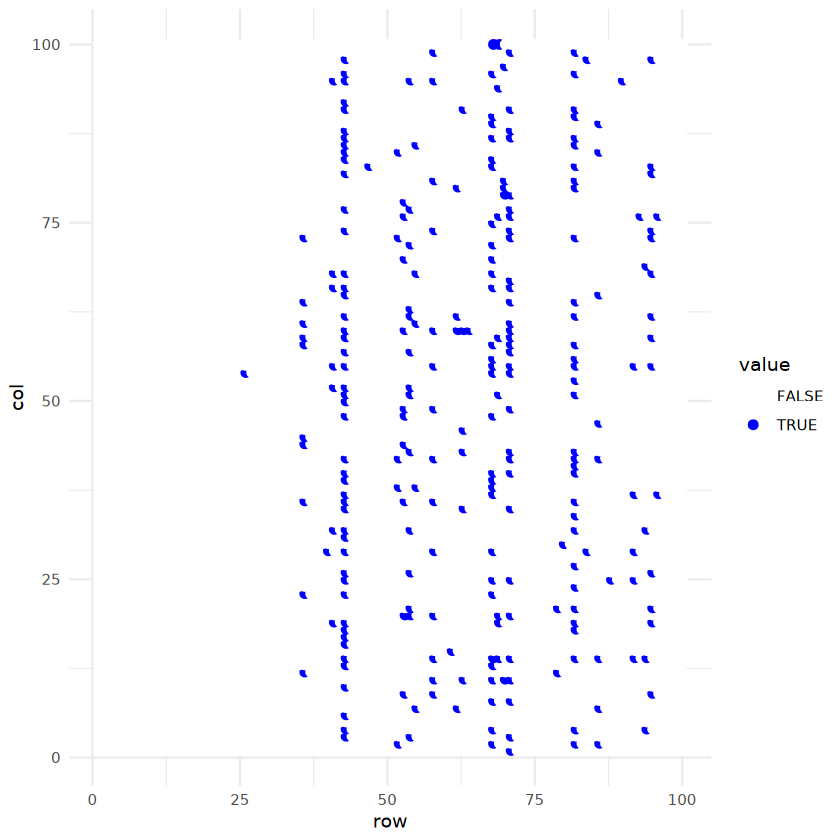

In [5]:
subsample %>% as.vector %>% 
  tibble(value = ., row = rep(1:nrow(subsample), times = ncol(subsample)),
                                         col = rep(1: ncol(subsample), each = nrow(subsample))) %>%
  ggplot(aes(x = row, y = col, colour = value)) +
  geom_point(size = 2) +
  scale_color_manual(values = c('white','blue'))+
  theme_minimal()

Looking at the map above of genes with 0 expression values (white space) compared to non-zero values (blue dots), you would appreciate the sparsity of the data.

<font color='red'> **Question**: What is the percent of zero values in this dataset? How many genes were universally expressed in all cells? <font> 

## 3 Exploratory data analysis (Quality control)

- Before doing any in-depth analysis to reach a biologically meaningful conclusion, it is essential to examine the data and remove low quality (outlier) cells and genes. We will go through the typical quality control (QC) analysis steps. We will remove cells with few genes and total detected reads, and also genes which are detected very rarely and at low abundance.

- It is also usual to remove cells that may have been damaged during tissue preparation; these are typically demarcated by unusually high levels of mitochondrial and ribosomal gene expression. 

### 3.1 QC statistics at cell levels

- In an scRNAseq experiment, each cell is compartmentalised into a separate oil droplet, and sequencing preparations occur in each droplet. Therefore, technical variation exists between cells. For example, some cells appear to have more reads that are mapped to mitochondrial genes (likely due to cells were stressed due to experimental handlings) or ribosomal genes (partly due to failure to capture other genes within the cells). Another example is that some cells have more sequencing reads or more genes detected than in the other cells. 

<font color='red'> **Question**: find how many mitochondrial and ribosomal genes in the dataset? Hints: look for gene symbols starting with 'MT-', 'RPL', 'RPS' <font>

In [50]:
gene_List <- rownames(pbmc@assays$RNA@features) # the same as: gene_List <- rownames(pbmc)

In [51]:
# Number of mitochondrial genes
print(paste0("Total Mt genes ", length(str_subset(gene_List, pattern = "^MT-"))))
# Number of ribosomal genes
print(paste0("Total Rb genes ", length(str_subset(gene_List, pattern = "^RPL|^RPS")))) 

[1] "Total Mt genes 13"
[1] "Total Rb genes 106"


<font color='red'> **Question**: Find Pearson correlation between the total reads per cell and total genes detected per cell (accurate to 2 decimal places). <font>

<font color='red'> **Question**: Generate a plot to assess the variation in the total reads per cell and total genes detected per cells across the 2700 cells. <font>

<font color='red'> **Question**: Why is there a positive correlation? Should this dataset be sequenced more to detect more genes (when the increase gets saturated)? <font>

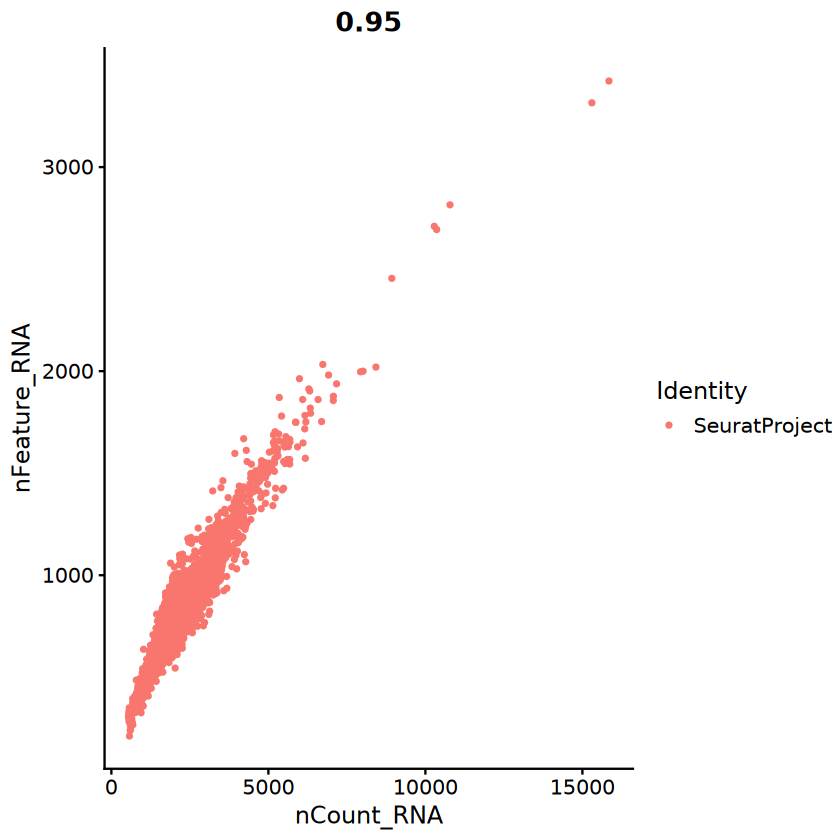

In [53]:
# Find the number of detected genes per cell. nCount = number of reads mapped to each cell, and nFeature = number of genes per cell
FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")

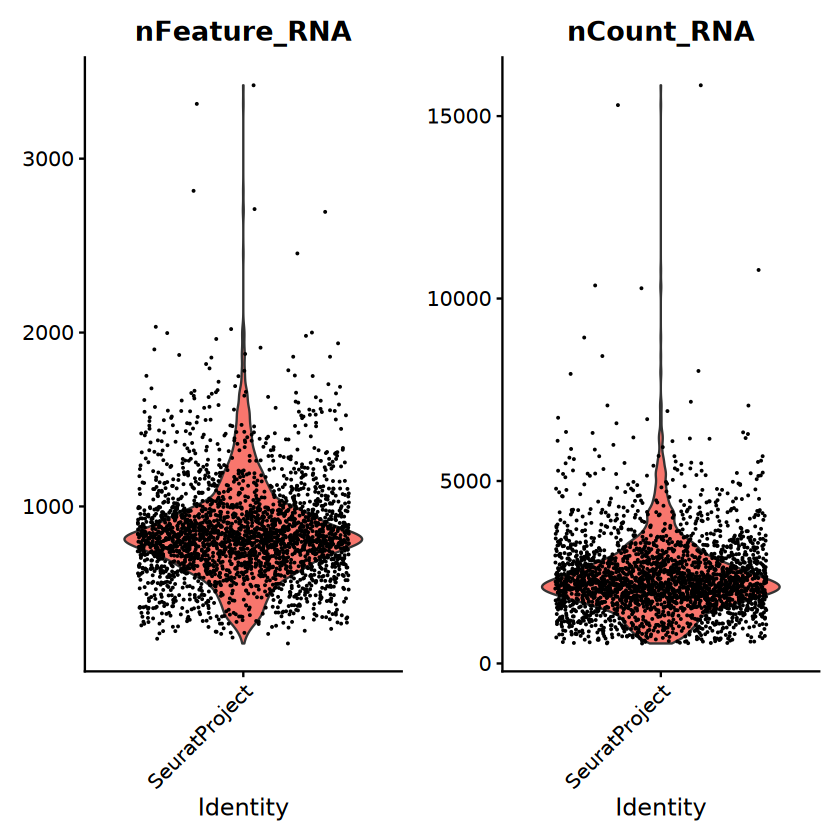

In [148]:
# Visualise QC metrics as a violin plot
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2)

<font color='red'> **Question**: Find Pearson correlation between total reads mapped to ribosomal genes per cell and total reads (i.e. reads across all genes) per cell). </font>

<font color='red'> **Question**: Generate a scatter plot of total reads mapped to ribosomal genes per cell and total genes per cell. Why cells with too many ribosomal reads can bias the comparison of all genes in a transcriptome? Hints: can start with the script below <font>

In [82]:
# get gene expression matrix 
data_matrix <- GetAssayData(pbmc, slot = "counts")

# QC statistics for some key genes 
mt_genes <- str_subset(gene_List, pattern = "^MT-") # another way to do this: mt_genes <- grep("^MT-", rownames(pbmc), value = TRUE) 
rb_genes <- str_subset(gene_List, pattern = "^RPL|^RPS")

# Find mitochondrial genes reads:
mt_genes_read <- colSums(data_matrix[mt_genes, ])

# Find ribosomal genes reads
rb_genes_read <- colSums(data_matrix[rb_genes, ])

# Calculate correlation between MT genes and total reads 
print(paste0("The correlation of total MT reads with total reads of all genes is ", round(cor(mt_genes_read,pbmc$nCount_RNA), 2)
     )) 
# Calculate correlation between Rb genes and total reads 
print(paste0("The correlation of total Rb reads with total reads of all genes i ", round(cor(rb_genes_read,pbmc$nCount_RNA), 2)
     ))
# Calculate percent of MT genes 
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

[1] "The correlation of total MT reads with total reads of all genes is 0.71"
[1] "The correlation of total Rb reads with total reads of all genes i 0.76"
[1] "The total of MT reads 59.8085748968159"


<font color='red'> **Question**: How many cells have more than 5% mitochondrial reads ?  </font> 
<font color='red'> How many cells have more than 50% ribosomal reads?  </font>

<font color='red'> **Question**: Compare cells containing >20% mitochondrial reads with the remaining cells (likely healthy cells)? Comment about whether these cells have signs of technical biases (e.g. expressing more stress response genes)? <font>

### 3.2 QC at genes level 

- In an scRNAseq experiment, lowly expressing genes can be misdetected (i.e. genes are expressed in the cells but have value as 0 in the gene expression matrix). These genes add noise to many downstream analysis types. Therefore, it is better to remove these genes. 

- So far we have looked at QC metrics for cells. Next we will examine metrics for genes. 

<font color='Red'> **Question**: How many percent of reads mapped to the top 100 genes with most reads? </font>  

Here we are asking you to first identify the 100 genes with the most reads mapping to them across all cells. Then we want you to calculate what is the percentage of reads that map to these genes compared to all genes.

In [75]:
# get gene expression matrix (uncomment and run the below command, if you havent done so in the previous steps): 
# data_matrix <- GetAssayData(pbmc, slot = "counts")

total_reads_per_genes <- apply(data_matrix, MARGIN = 1, FUN = 'sum')
sorted_genes_based_count <- sort(total_reads_per_genes,decreasing = T)
top100 <- sorted_genes_based_count[1:100]
pct_top100 = sum(top100)/sum(total_reads_per_genes)*100
print(paste0("Percent of reads mapped to top 100 genes ", round(pct_top100,2)))

[1] "Percent of reads mapped to top 100 genes 51.27"


In [74]:
top100

MALAT1  TMSB4X     B2M   RPL10   RPL13  RPL13A     FTL    RPS2    RPS6    FTH1 
 161685  124210  121363   88517   77111   76843   74702   65155   62546   57341 
  RPS18   RPL11   RPL32    RPS3   RPL19   RPS12   RPLP1    ACTB    RPL3   RPS27 
  55413   51634   51592   51025   49028   48256   47450   47363   47212   45094 
  RPS19   RPS14  EEF1A1  RPL18A  MT-CO1   RPL28  TMSB10   RPS4X   RPLP2   RPL21 
  43858   43308   41904   40979   39191   38630   37306   37171   35684   35001 
  RPL15   RPS3A  RPS15A  RPL23A  RPS27A  RPL27A   RPL12    RPL6    RPS8     LYZ 
  34935   34451   33154   32711   31447   31201   31199   29927   29107   27666 
  RPL26    TPT1   RPS15   RPL14  RPL10A    RPS7    RPL9    RPL8    RPS9   RPS16 
  27247   27182   26956   26676   25807   25642   25543   25320   24995   24888 
   RPS5   RPL29   RPS23   RPL30    RPL7   RPL18    PTMA    CD74   HLA-C   RPS25 
  24632   24517   24445   23656   23549   23084   23038   23018   22564   22217 
  RPL7A  RPL35A   RPL34  GNB2L1    RPL5    RPSA   RPL31  S100A4   RPS10  MT-CO3 
  21211   21046   20745   20555   20452   20361   20014   19598   19515   19290 
 MT-CO2    JUNB   RPS13     FAU   HLA-A    EIF1   RPL35    NACA   UBA52 HLA-DRA 
  19084   18863   18766   18674   18431   18028   17742   17417   16908   16467 
 S100A9   RPLP0   RPS28    RPL4     FOS   RPL17    PFN1   RPS20   RPL36   H3F3B 
  16326   16184   16128   15607   15579   15413   14394   14346   14257   14036 
 MT-ND4   RPL27  RPL37A   RPL37   RPS11   HLA-B    OAZ1   EEF1D   RPS24  MT-ND1 
  13760   13742   13555   13482   13263   13247   13238   13130   13056   13011

<font color='Red'> **Question**: Using gprofiler (or scanpy wrapper of gprofiler), find the most enriched ontology group these top genes represent. <font>  
    
How many of the top 10 most significant GOs are related to translation and ribosomal processes?
    
Hint: you'll probably need to check out the `scanpy` and `gprofiler` documentation for this one!

<font color='red'> **Question**: Are these top 100 genes informative about gene regulation processes (e.g. when comparing diseased vs healthy conditions)? <font>

### 3.3 Removing cell and gene outliers 

- So far we have assessed the possible noisy data coming from cells and genes due to experimental constraints. Next, we will look at how to remove the noise. 

#### Removing poor quality cells 

In [18]:
# pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

# pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

- <u> *Discussion:* </u> A traditional way to filter cells using a 'hard' thresholds is to remove cells with too many genes (e.g. more than 2500 genes, or has more than 5% of mitochondrial reads).  A better way to remove outlier cells is to use dataset-dependent distribution to define thresholds that are less/not dependent on outlier values.

- Here we use median absolute deviation (MAD), calculated by the following formula: MAD = median(| x - median(x)|) 
- If we use +- 3*MAD as a range to define lower and upper bounds (values adaptively change between datasets), we can consistently remove outliers. 
- We can apply the method above using MAD of total genes per cell for filtering. Cells with fewer than the lower bound have low transcriptome diversity, while cells with more than the upper bound genes may be considered over abundant in the number of genes detected. 

<font color='red'> **Question**: Assuming potential outlier cells are those outside the median +- 3xMAD genes per cell range. How many cells are potential outlier cells? </font> 

Note we expect you to use: `>` and `<` i.e. not `>=` or `<=`

Tip: You need to caculate the MAD (Mean absolute deviation) for the `number of genes` per cell (the scipy stats package might help with this!) and then find the cells that are outside the +- 3xMAD range.

<font color='red'> **Question**: Compare outlier cells with the remaing cells by using metrics like mitochondial and ribosomal reads, top abundant genes, and/or differentially expressed genes. Do you think these potential outlier cells should be removed and why? <font>

In [85]:
total_genes_per_cell <- pbmc$nFeature_RNA
threeMAD_total_genes <- 3 * mad(total_genes_per_cell,constant = 1)
lower_bound <- median(total_genes_per_cell) - threeMAD_total_genes
upper_bound <- median(total_genes_per_cell) + threeMAD_total_genes

# Number of outlier cells
counter <- 0
for (ttg in total_genes_per_cell) {
    if (ttg < lower_bound || ttg > upper_bound) { 
        counter = counter + 1  
        }
    }
print(paste("The number of outlier cells is: ", counter) )


[1] "The number of outlier cells is:  353"


[1] "Number of cells after filtering cells: 2347"


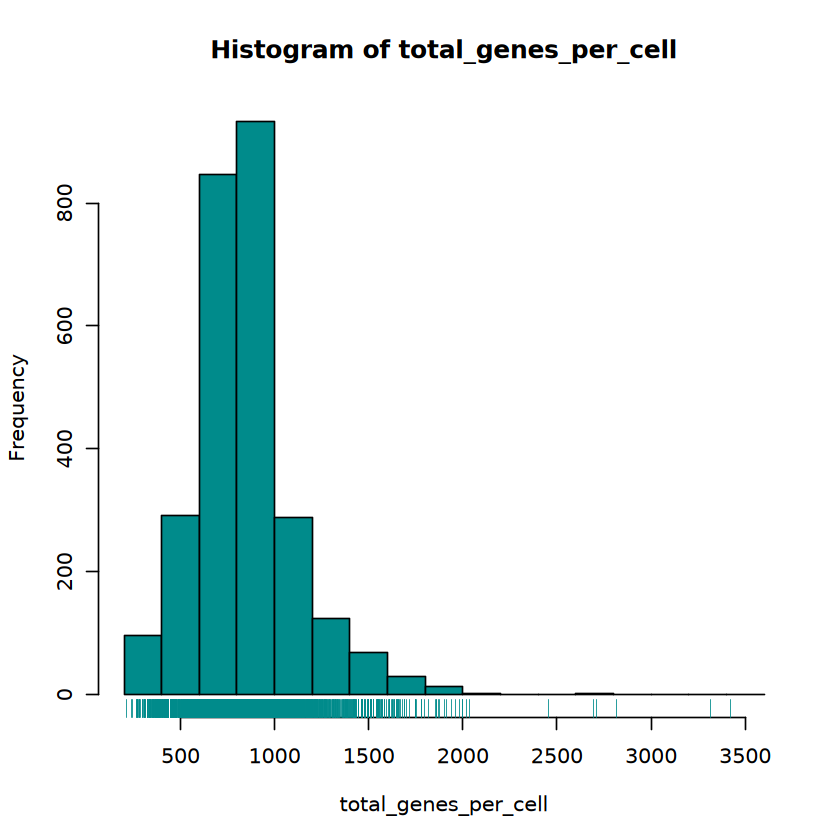

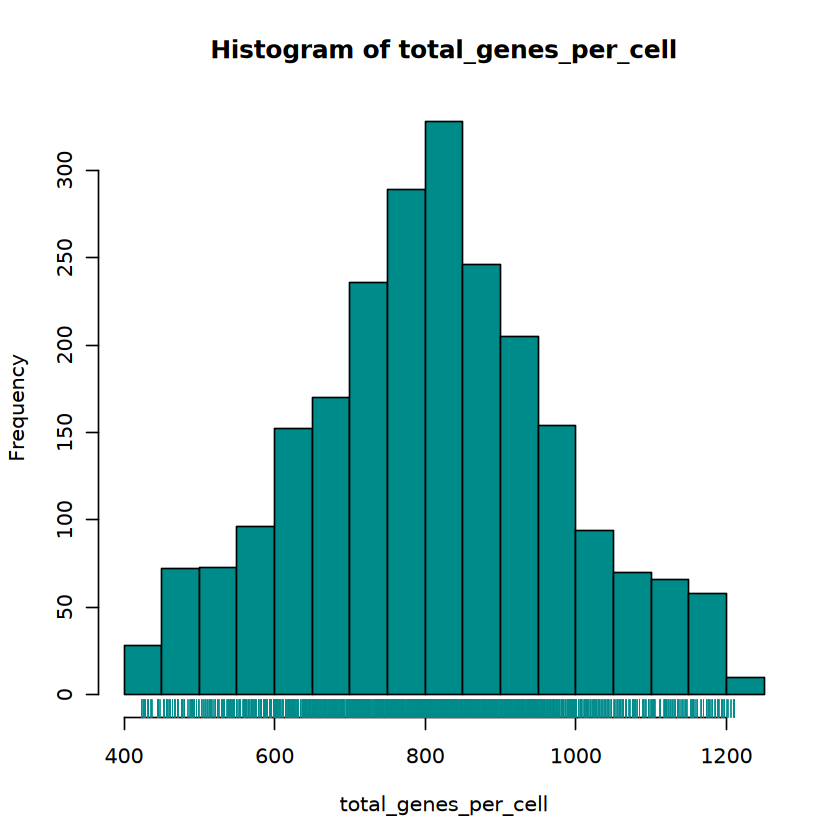

In [86]:
# Before filtering cells 
hist(total_genes_per_cell, col = "cyan4")
rug(total_genes_per_cell, col = "cyan4")

pbmc_filtered <- subset(x = pbmc, subset = nFeature_RNA > lower_bound)
pbmc_filtered <- subset(x = pbmc_filtered, subset = nFeature_RNA < upper_bound)
print(paste0('Number of cells after filtering cells: ', dim(pbmc_filtered)[2]))

total_genes_per_cell <- pbmc_filtered$nFeature_RNA

# After filtering cells 

hist(total_genes_per_cell, col = "cyan4")
rug(total_genes_per_cell, col = "cyan4")

#### Removing unreliably detected genes

- Many of the 32,738 genes have 0 expression values in all cells. These genes can be removed from downstream analysis.
- Further, genes that only found in one cell would likely be technical noise or transcriptional randomness. Analysis of these genes will not yield significant results. 
- For some cases, the lower bound calculated by the 3MAD formula is less than 0, so there is no point using it as a cutoff. We reasoned that for a gene to be reliably detected, it needs to be detected in at least three cells (or as a minimum, in two cells), so we use a 'hard' cutoff of 3 cells in this case. 
- We can see that the number of reliably detected genes was much lower than the total number of genes that could possibly be mapped. This observation is reaseanable, given that only a subset of all genes are active in any certain cell types. Removing noisy genes makes the analysis faster and more accurate (e.g. when scaling the whole dataset, noisy genes will get the same weight as informative genes).

## 4 Normalisation (between cells) 

- In this dataset, there is one sample (one experimental condition/replicate), so we won't go through between sample normalisation. However, we will still need to perform between cell normalisation. 
- In scRNA-seq data, sequencing data for each cell is separate from other cells (e.g. each cell is compartmentalised into one oil droplet, and reactions happen within each oild droplet), therefore technical variation happens between cells.
- We will scale the original data so that each cell will have 10,000 reads, maintaining the distribution of gene abundance within each cell, globally scaling genes up or down. Global scaling is a fast and simple way for cell-to-cell normalisation. However, more accurate normalisation methods are available and will be discussed in the lecture, but will not be tested here due to the long running time and large computer memory required. For example, scran and scTransform are two better methods compared to global scaling

### 4.1 Normalisation to a constant library size 

In [91]:
# get gene expression matrix 
data_matrix <- GetAssayData(pbmc, slot = "counts")

reads_per_cells <- colSums(data_matrix)
# set the total number of reads after scaling normalisation as 1e4 (i.e. assuming every cell has the same number of reads mapped to the cells as 1e4 reads)
after <- 1e4 
counts <- reads_per_cells
scale_factors <- counts / after   # scale factor for each cell 

data_matrix_norm <- t(apply(data_matrix, 1, function(x) x/scale_factors))
reads_per_cells_norm <- colSums(data_matrix_norm)
summary(reads_per_cells_norm) # confirm that all cells have total reads ~1e4

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10000   10000   10000   10000   10000   10000 

### 4.2 Normalisation by median 

- Section 4.1 above shows how one can normalise the dataset so that each cell has 10,000 reads per cell after normalisation. This approach is common, but is not always ideal because there are cases that some datasets have deeper sequencing and thus most cells may have more than 10,000 reads. In these cases, setting every cell to have 10,000 reads will lead to information loss.

<font color='red'> **Question**: Normalise by adusjusting the total reads per cell to a median value between all cells. How many cells have scale factors greater than 1? </font> 

In [149]:
# get gene expression matrix 
data_matrix <- GetAssayData(pbmc, slot = "counts")

reads_per_cells <- colSums(data_matrix)
counts <- reads_per_cells
after <- median(counts)  # if after is not provided, normalise everything to the median count
scale_factors <- counts / after   # scale factor for each cell 
print(paste0("Number of cells with scale factor >1: ", length(scale_factors[scale_factors > 1.0])))

data_matrix_norm <- t(apply(data_matrix, 1, function(x) x/scale_factors))

[1] "Number of cells with scale factor >1: 1349"


### 4.3 Assess normalisation effects 

- Save raw data, before replaced by normalised data. Set the .raw attribute of AnnData object to freeze the state of the AnnData object. You can get back an AnnData of the object in .raw by calling .raw.to_adata()

In [150]:
# Write the normalised matrix to pbmc object 

norm_assay <- CreateAssayObject(counts = data_matrix_norm)
pbmc[["RNA_norm"]] <- norm_assay
data_matrix_norm <- GetAssayData(pbmc, slot = "counts", assay = "RNA_norm")

In [151]:
# You can restore the value before normalisation 
data_matrix <- GetAssayData(pbmc, slot = "count")
data_matrix_norm <- GetAssayData(pbmc, slot = "counts", assay = "RNA_norm")

In [152]:
gene <- 'ACTB'

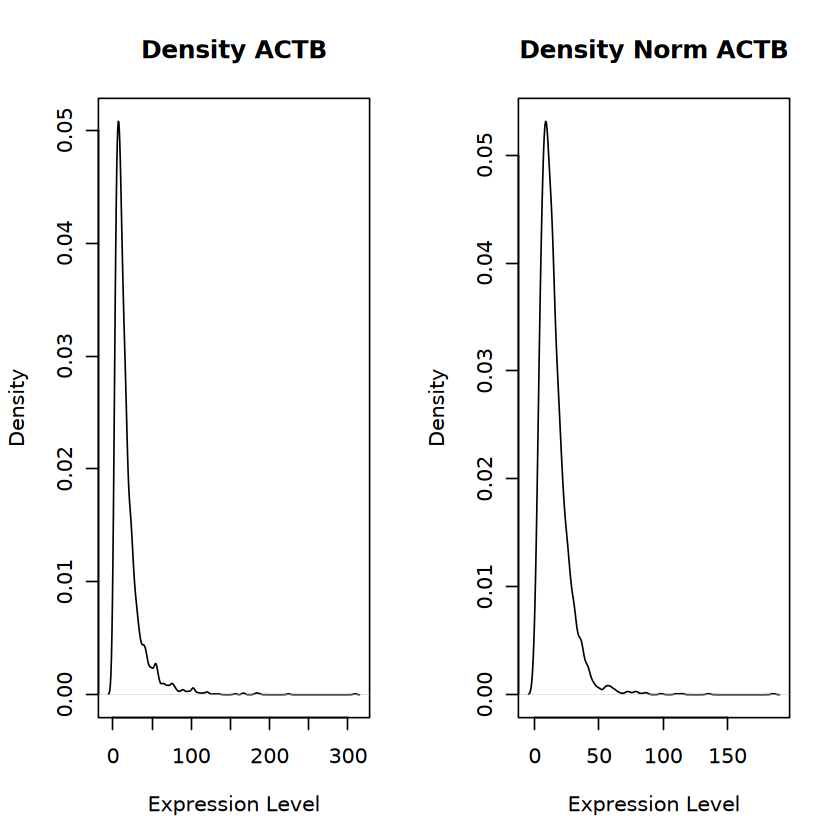

In [153]:
par(mfrow=c(1,2))
plot(density(data_matrix[gene,]), main = paste("Density", gene), xlab = "Expression Level", ylab = "Density")

plot(density(data_matrix_norm[gene,]), main = paste("Density Norm", gene), xlab = "Expression Level", ylab = "Density")

In [154]:
library(ggplot2)

In [155]:
before <- as.data.frame(data_matrix[gene,])
names(before) <- c("count")
before_p <- ggplot(before, aes(x=count,y=count)) + 
  geom_violin() + ggtitle(paste("Expression ", gene)) 

In [156]:
after <- as.data.frame(data_matrix_norm[gene,])
names(after) <- c("count")
after_p <- ggplot(after, aes(x=count,y=count)) + 
  geom_violin() + ggtitle(paste("Expression Norm ", gene)) 

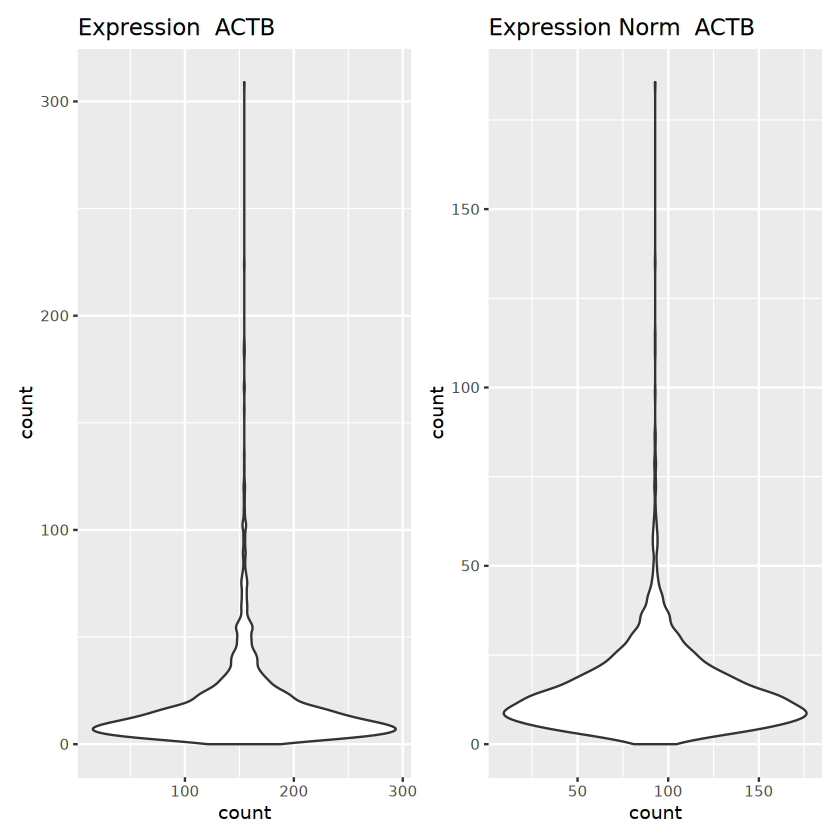

In [157]:
before_p + after_p

## 5 Dimensionality reduction 

- Dimension reduction seeks to produce a low dimensional representation of high dimensional data that preserves relevant structure. Dimension reduction is needed in single cell data analysis for representation, noise reduction, faster computation and contributing to solving the “curse of dimensionality”. 

- The “curse of dimensionality” refers to the fact that the number of observations (n) needed to estimate parameters (e.g. classification parameters in a logistic classifier for single cells) increases rapidly when the number of input variables (e.g. p genes or p dimensions) increases.

- scRNA-seq data with many genes and so many cells can have a lot of technical noise (e.g. very few copies of a gene in a cell may be missed by PCR reaction during single cell sequencing).  

- By analysis such as the Principal Component Analysis (PCA), each principal comnponent can be thought of as a 'metagene' or a latent (unseen, unknown) 'metafeature' that combines information across a correlated gene set or experimental/biological conditions. 

- The use of the top principal components that explain most variation in the dataset can be considered as a way to compress/represent/simplify the dataset without loosing much information (i.e. preserving the data structure). 

### 5.1 Linear dimensionality reduction 

- PCA applies orthogonal transformation to the initial Euclidean distance matrix derived from the full expression matrix containing all genes. The method creates low-dimensional embeddings that best preserves the overall variance of the dataset.

- Before PCA, we will scale the data (also called standardization), so that the data structure won't be affected by just abundant genes. After scaling, each gene will have expression value with standard deviation equal 1 (by dividing each gene expression value for a cell by the standard deviation of that genes across all cells in a sample) and mean equal 0 (substract each gene expression value by the sample mean). It is important to think about how this scaling step can affect the weighting/importance of lowerly expressed genes.


In [160]:
# Reload the data to start fresh 
expression_matrix = Read10X('/data/module2/data/prac1_singlecell/filtered_gene_bc_matrices/hg19',  # the directory with the `.mtx` file  
    )
pbmc <- CreateSeuratObject(counts = expression_matrix)

# Quick and convenient normalisation (not optimal)

pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)
# Find top variable genes 
pbmc <- FindVariableFeatures(object = pbmc)

#  Scale data before PCA,  each gene has mean expression 0 and the variance across cells 1 to give equal weight in downstream analyses
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)

# PCA 
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  MALAT1, CD2, ACAP1, STK17A, CTSW, CD247, CCL5, GIMAP5, GZMA, TRAF3IP3 
	   MAL, MYC, ETS1, LDLRAP1, RIC3, LYAR, KLRG1, TNFAIP8, PRF1, TRABD2A 
	   NCR3, FAM107B, CD79A, TCL1A, PTPN4, MS4A1, LINC00926, FGFBP2, GZMH, ARID5B 
Negative:  LST1, TYROBP, AIF1, FTL, FCN1, TYMP, SERPINA1, LGALS2, SPI1, SAT1 
	   COTL1, CFP, IFI30, NPC2, GSTP1, OAZ1, MS4A6A, FCGRT, TNFSF13B, S100A4 
	   CEBPB, HLA-DRB1, AP2S1, FPR1, SRGN, TALDO1, HLA-DRB5, HLA-DPA1, ATP6V0B, SMCO4 
PC_ 2 
Positive:  PRF1, GZMA, CTSW, FGFBP2, GZMH, CCL5, CD247, FCGR3A, XCL2, CLIC3 
	   SRGN, AKR1C3, S100A4, ANXA1, TTC38, ID2, ACTB, XCL1, TMSB4X, APOBEC3G 
	   KLRG1, LYAR, GAPDH, IFITM2, ABI3, DHRS7, GIMAP4, PDIA3, ARPC5L, HAVCR2 
Negative:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1, LINC00926, CD79B, HLA-DRB1, HLA-DMA, HLA-DRB5 
	   HLA-DPA1, P2RX5, BLNK, KIAA0125, SWAP70, SMIM14, ARHGAP24, PPP1R14A, RP11-428G

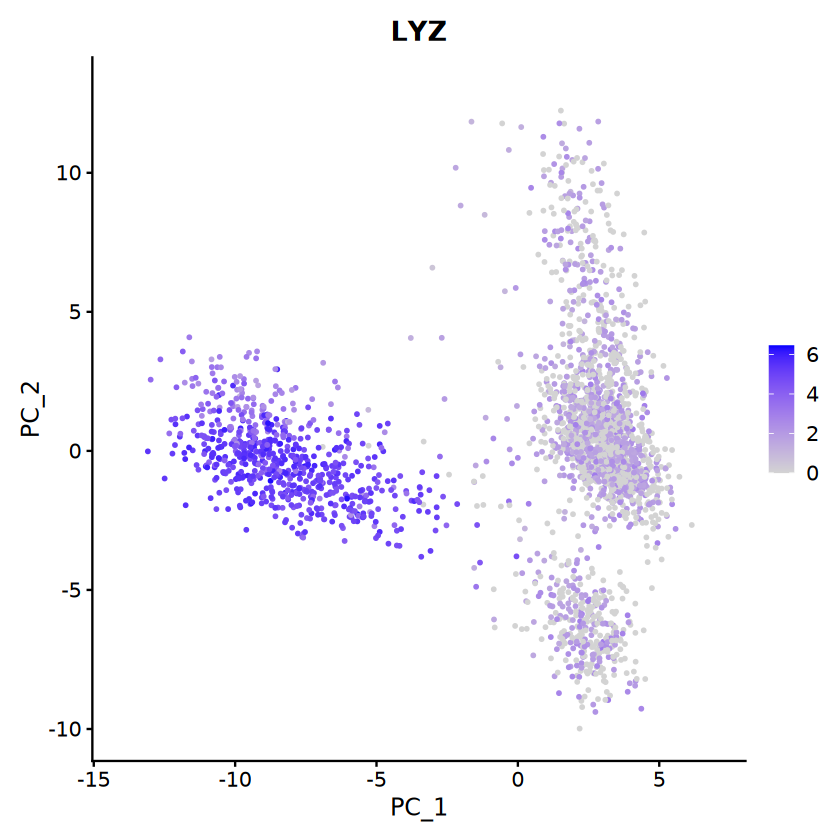

In [161]:
FeaturePlot(pbmc, features = c("LYZ"),dims = c(1,2))

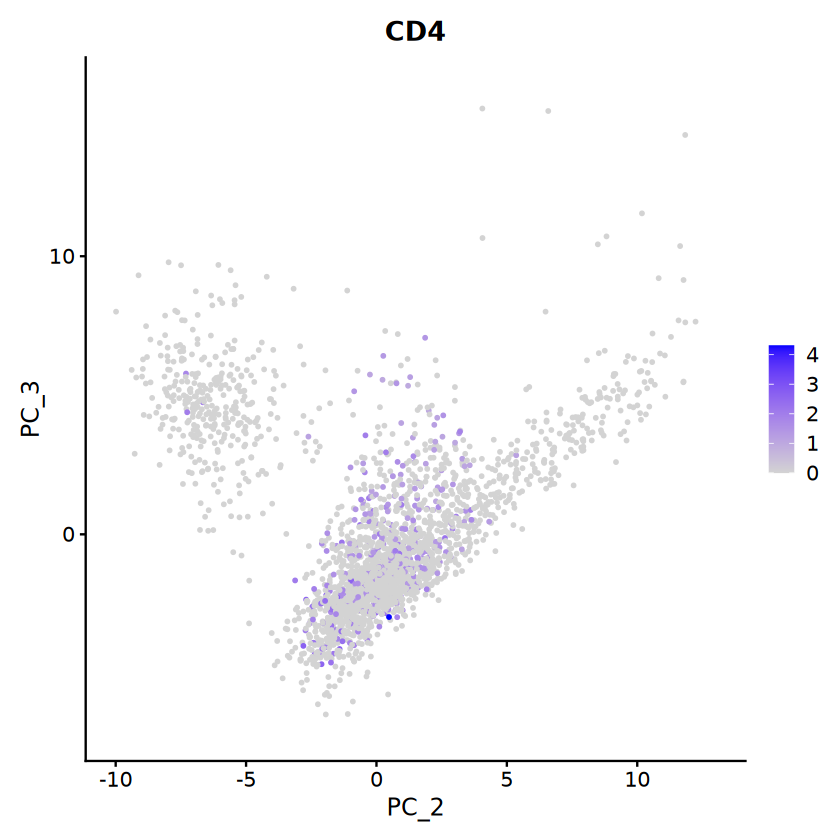

In [162]:
FeaturePlot(pbmc, features = c("CD4"),dims = c(2,3))

<font color='red'> **Question** : What is the percent of the variance in the dataset that the first 500 PCs can explain? Note: scaling the data across genes to unit variance and 0 mean is needed (it is interesting to think about the need to do this for gene expression data) </font>

In [165]:
data_matrix <- GetAssayData(pbmc, slots = "count")
pca_result <- prcomp(data_matrix)
tmp <-summary(pca_result)
print(paste0("Percent variance explained by the first 500 PCs ",round(sum(sum(tmp$importance[2,1:500]))*100, 2), "%"))

[1] "Percent variance explained by the first 500 PCs 75%"


<font color='purple'> **Question**: How is this percent of variance explained in PCA analysis of scRNA-seq data different to a typical PCA analysis for a standard RNA-seq dataset? <font>

### 5.2 Nonlinear dimensionality reduction 
- Nonlinear dimensionality reduction techniques take a set of points in a high-dimensional space and find a representation of those points in a lower-dimensional space, typically a 2-to-3 dimensional plane, in such a way that local and global structure of the data are preserved as much as possible. Nonlinear techniques are able to avoid overcrowding of the representation, i.e. they can separate cell populations in a 2-to-3 dimensional space.

In [166]:
# Find neighbor in PCA space, estimating connectivities of data points
# You may want to change n_neighbors and see how does it affect the results in local and global view of the UMAP plots

pbmc <- FindNeighbors(pbmc, dims = 1:40)

Computing nearest neighbor graph

Computing SNN



#### Use Uniform Manifold Approximation and Projection (UMAP) 

In [167]:
# Embedding the neighborhood graph
pbmc <- RunUMAP(pbmc, dims = 1:10)

13:25:22 UMAP embedding parameters a = 0.9922 b = 1.112

13:25:22 Read 2700 rows and found 10 numeric columns

13:25:22 Using Annoy for neighbor search, n_neighbors = 30

13:25:22 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:25:22 Writing NN index file to temp file /tmp/Rtmp0jJEAw/file152ce762b0d90

13:25:22 Searching Annoy index using 1 thread, search_k = 3000

13:25:24 Annoy recall = 100%

13:25:24 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

13:25:25 Initializing from normalized Laplacian + noise (using RSpectra)

13:25:25 Commencing optimization for 500 epochs, with 108380 positive edges

13:25:29 Optimization finished



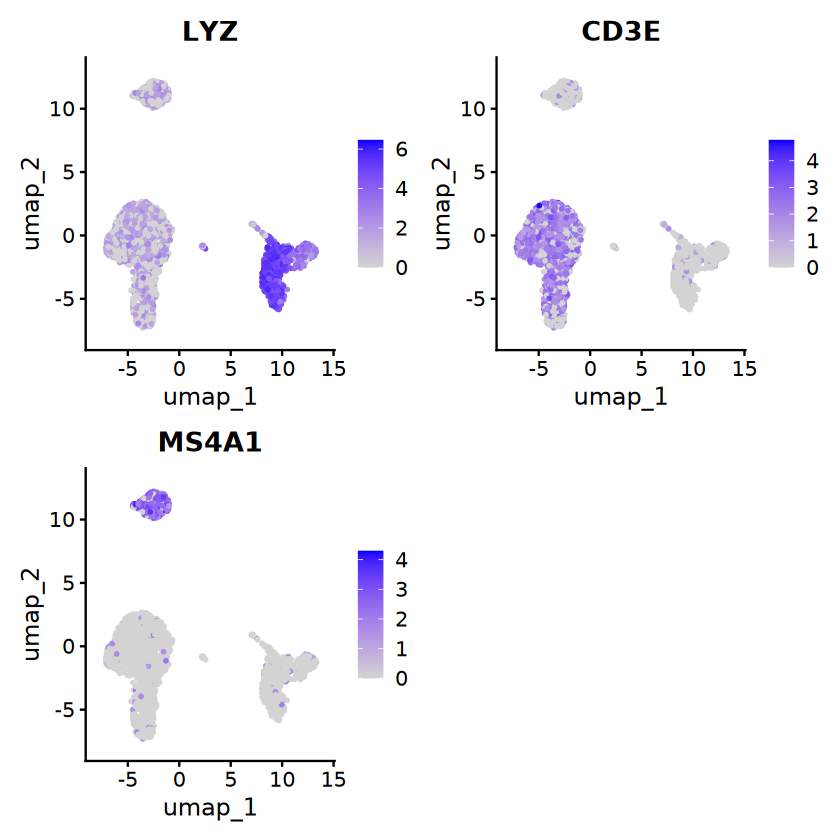

In [168]:
FeaturePlot(pbmc, features = c('LYZ','CD3E','MS4A1'), reduction = "umap")

<font color='red'> **Question**: What are the differences in the visualisation of UMAP with low n_neighbour =10 vs n_neighbour = 30? Why the n_neighbour parameter can make such differences? </font>

#### Use t-distributed Stochastic Neighbour Embedding (tSNE) 

In [172]:
pbmc <- RunTSNE(pbmc, dims = 1:10, seed.use = 1)

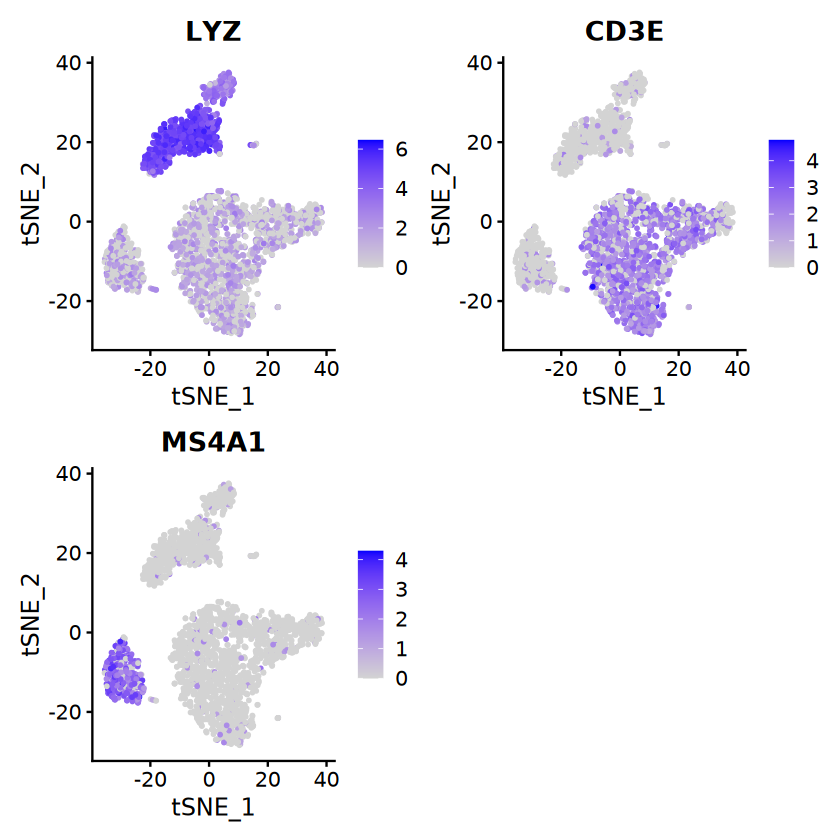

In [173]:
FeaturePlot(pbmc, features = c('LYZ','CD3E','MS4A1'), reduction = "tsne")

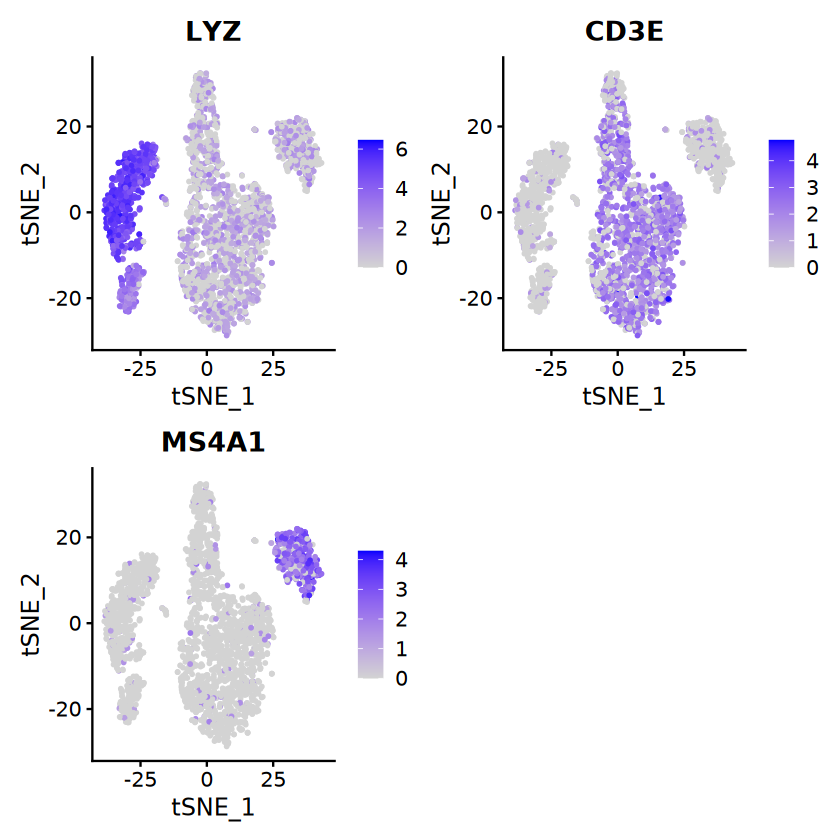

In [175]:
# what if we run tSNE again (for this example, the dataset is pretty small, so if you have time, you can run this - Note we set rando state (seed) to 2, you can try different numbers)
pbmc <- RunTSNE(pbmc, dims = 1:10, seed.use = 10)
FeaturePlot(pbmc, features = c('LYZ','CD3E','MS4A1'), reduction = "tsne")

<font color='purple'> **Question**: why are the results from the two tSNE plots different? </font>

## 6 Clustering 

- Our dimensionality reduction methods show cells such that those which express similiar genes are closer together; while those which express genes differently are further apart. Since cells of the same type will typically express the same genes, it follows these 'clusters' of cells may represent biologically meaningful cell types. 

- In order to group our cells based on their gene expression, we can utilise different clustering strategies.
We will explore the most common of these below.

### 6.1 Kmeans clustering 

In [176]:
pbmc@meta.data[, "kmeans"] <- kmeans(x = pbmc@reductions[["pca"]]@cell.embeddings[,1:50],
        centers = 3, nstart = 100)$cluster

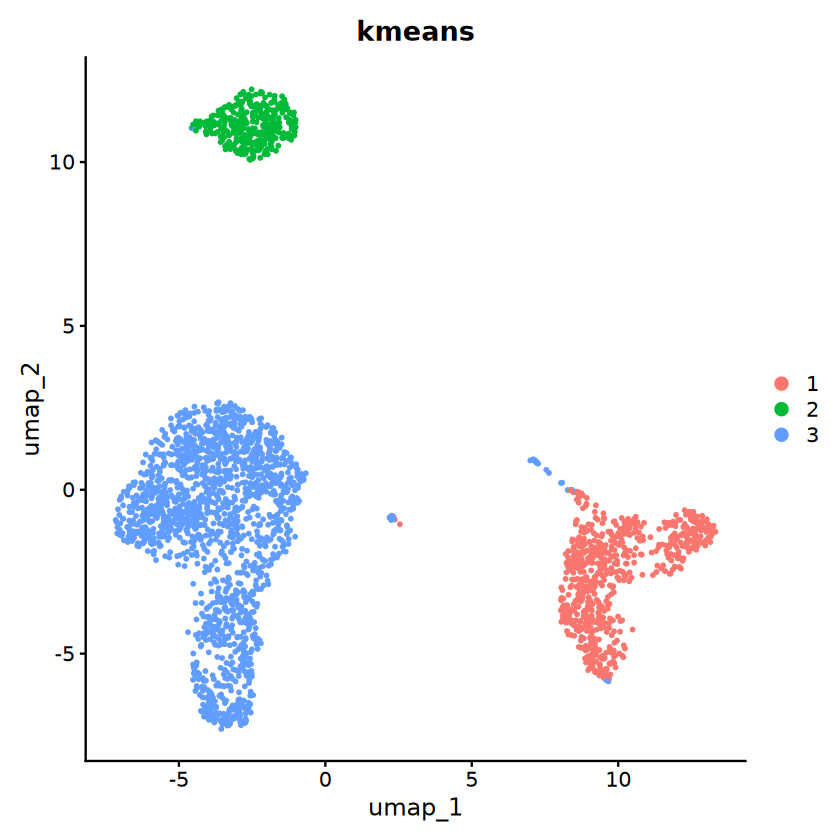

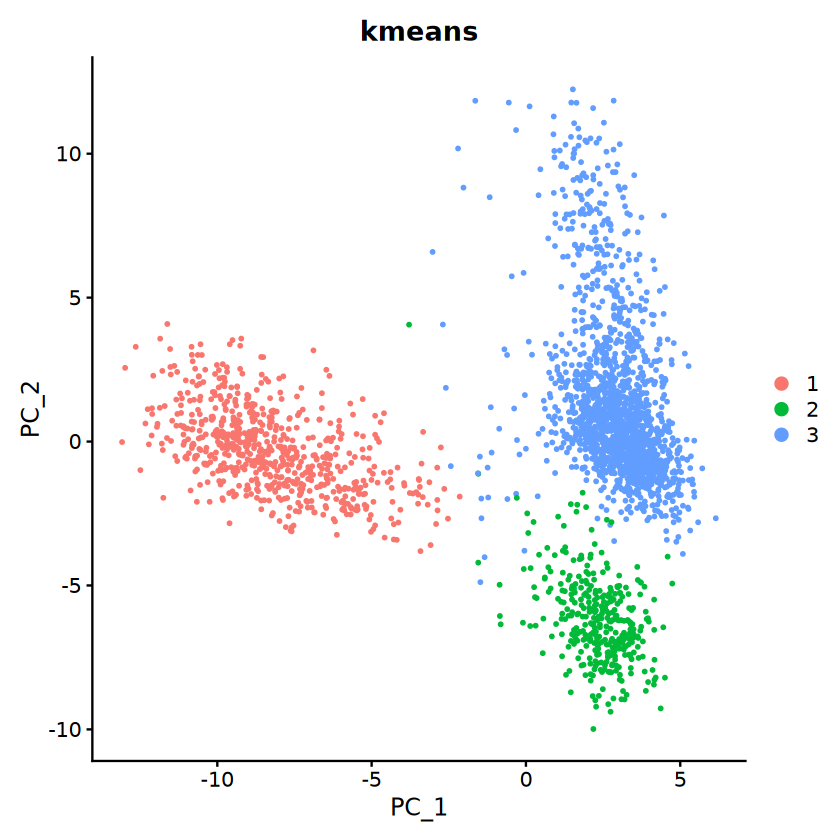

In [177]:
DimPlot(pbmc, reduction = "umap", group.by = "kmeans")
DimPlot(pbmc, reduction = "pca", group.by = "kmeans")

<font color='red'> **Question**: why can't the first two PCs separate cell clusters in a two-dimensional space? </font>

### 6.3 Graph based clustering 

In [178]:
pbmc <- FindClusters(pbmc, resolution = 0.5)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2700
Number of edges: 171971

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8452
Number of communities: 7
Elapsed time: 0 seconds


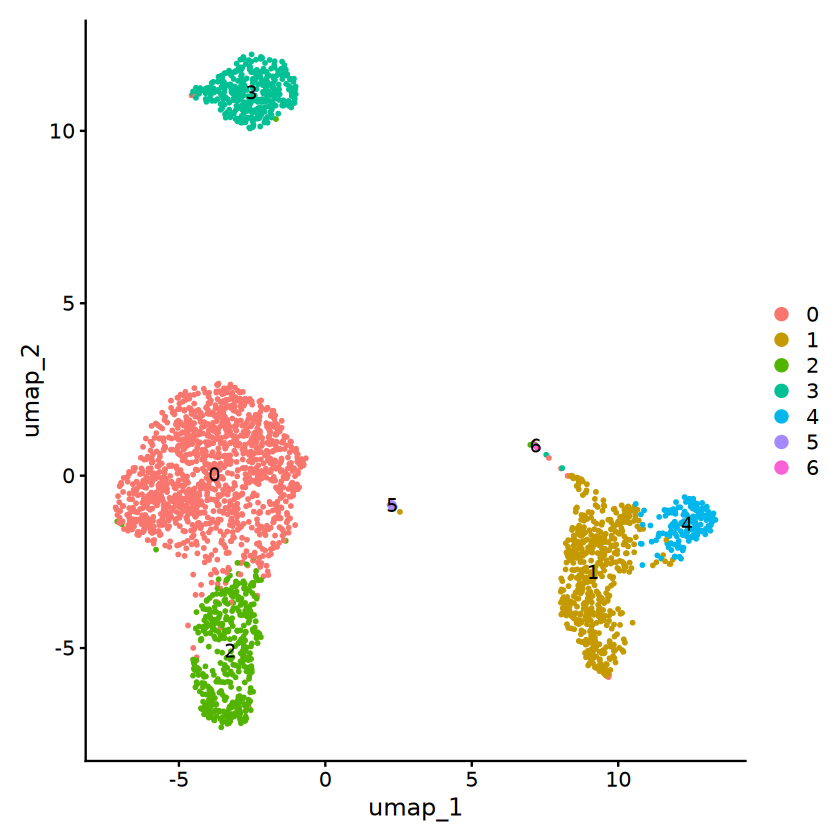

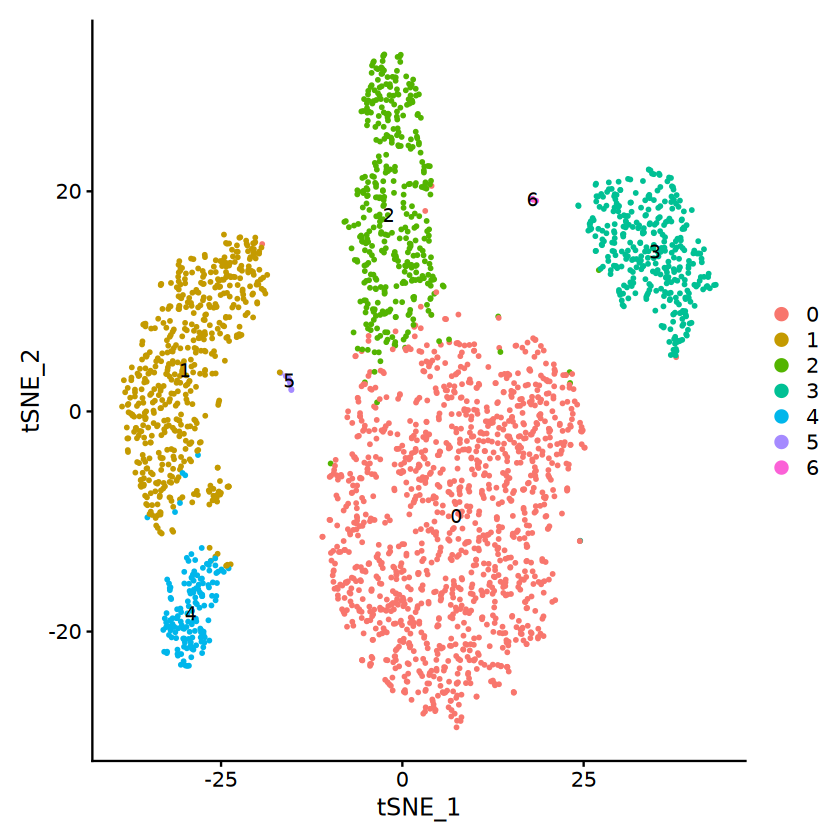

In [179]:
DimPlot(pbmc, reduction = "umap", label = TRUE)
DimPlot(pbmc, reduction = "tsne", label = TRUE)

<font color='red'> **Question**: For a fun excercise, rerun KMeans clustering with K=8 then  plots sc.pl.umap with KMeans labels and another plot with Leiden labels. Which plot separates clusters better? </font>

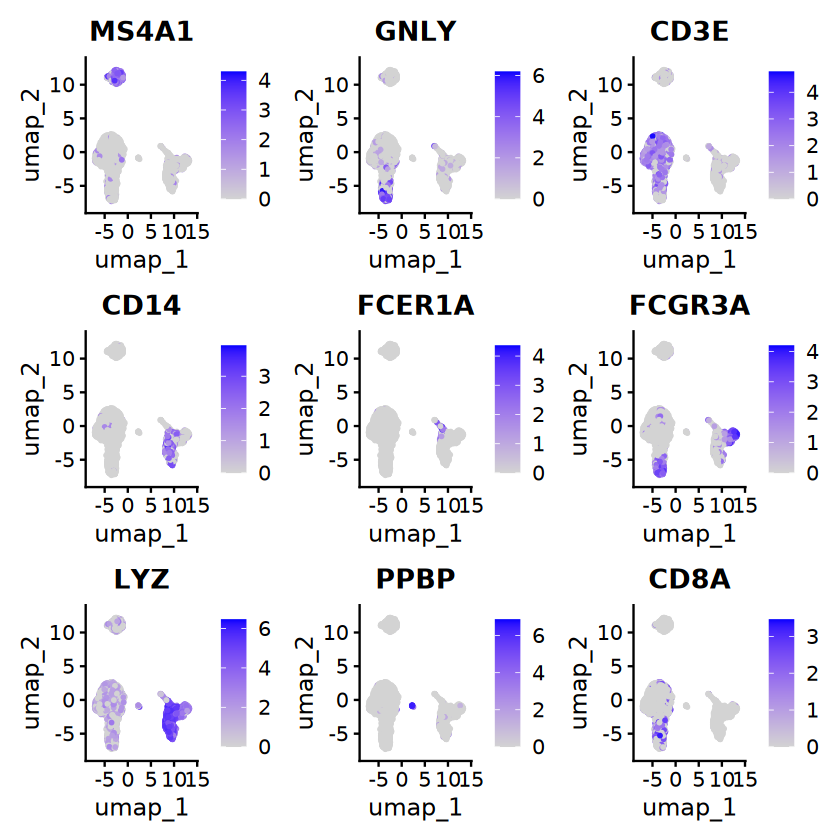

In [180]:
FeaturePlot(pbmc, features = c("MS4A1", "GNLY", "CD3E", "CD14", 
                               "FCER1A", "FCGR3A", "LYZ", "PPBP", "CD8A"))

<font color='blue'> We assign the clusters a cell-type label based on the marker genes identifyied for each cluster

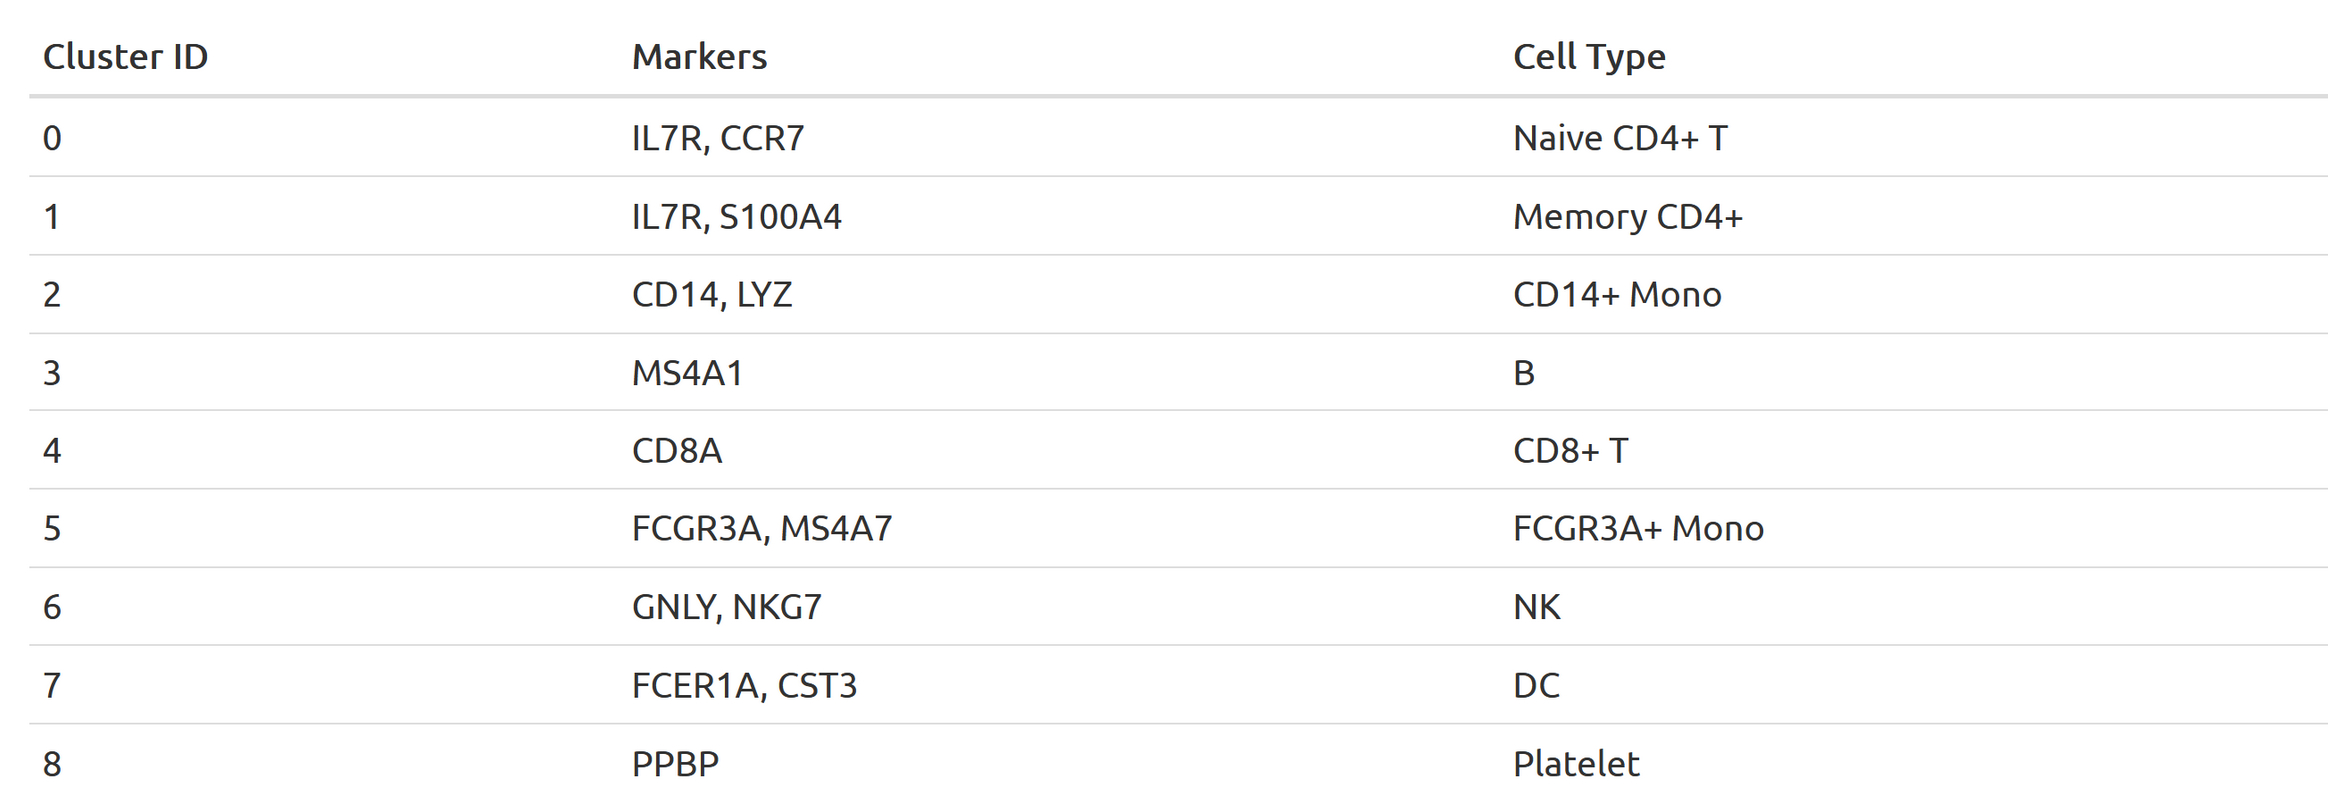

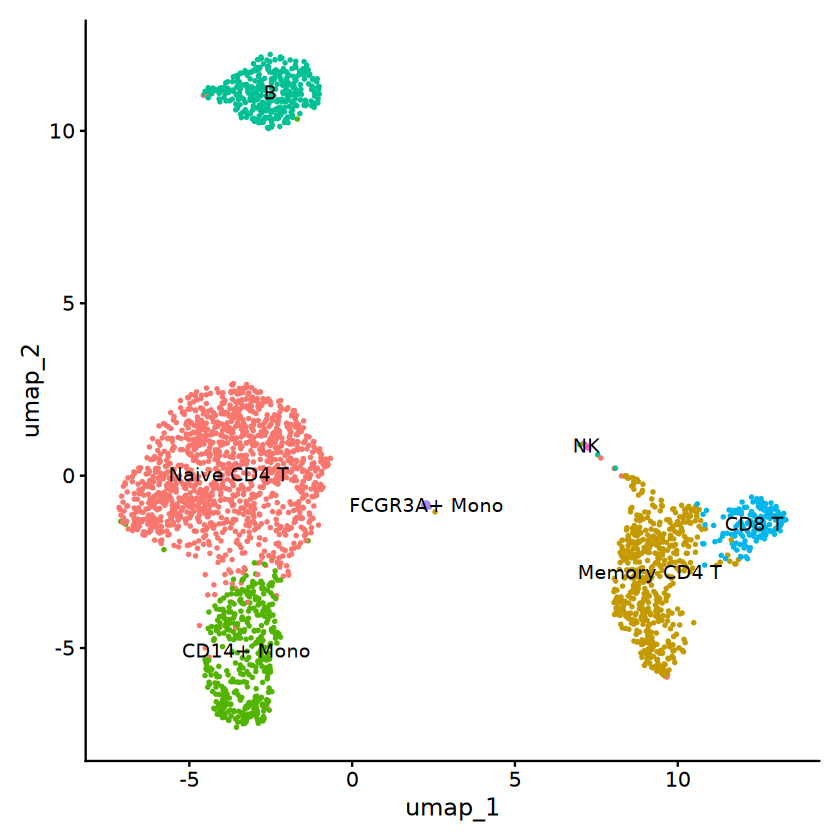

In [181]:
new.cluster.ids <- c("Naive CD4 T", "Memory CD4 T", "CD14+ Mono", "B", "CD8 T", "FCGR3A+ Mono", 
    "NK", "DC", "Platelet")
names(new.cluster.ids) <- levels(pbmc)
pbmc <- RenameIdents(pbmc, new.cluster.ids)
DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()